In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from tqdm import trange

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
torch.set_printoptions(sci_mode=False)

from sklearn.model_selection import train_test_split

In [22]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [23]:
y = train_df['label'].values
X = (train_df.iloc[:,1:].values).astype('float32')
X.shape,y.shape

((42000, 784), (42000,))

In [24]:
X,y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([1, 0, 1, ..., 7, 6, 9]))

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X,y,stratify=y,random_state=42,test_size=0.20)
X_train.size, X_val.size, y_train.size, y_val.size

(26342400, 6585600, 33600, 8400)

In [12]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_val = X_val.reshape(X_val.shape[0], 28, 28)
X_train.size, X_val.size, y_train.size, y_val.size

(26342400, 6585600, 33600, 8400)

In [7]:
X_train_tensor = torch.tensor(X_train)/255.0
y_train_tensor = torch.tensor(y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)

In [8]:
X_val_tensor = torch.tensor(X_val)/255.0
y_val_tensor = torch.tensor(y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)

In [9]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)

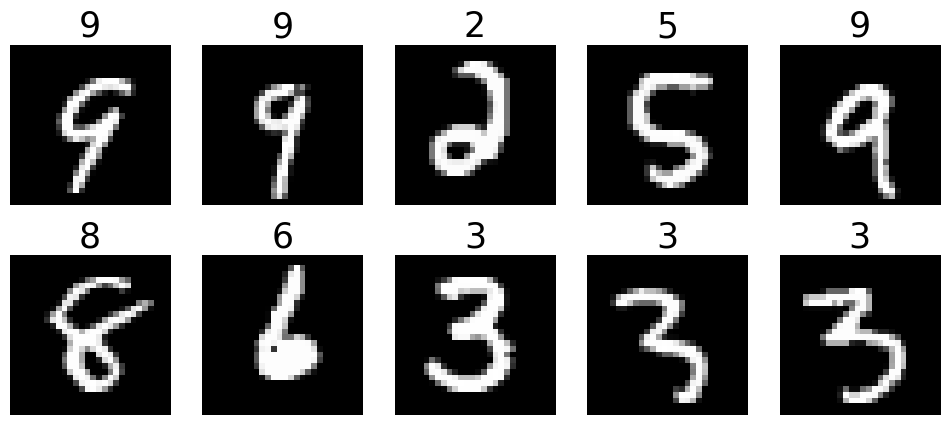

In [10]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,33600,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [12]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [13]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [14]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))
            
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = conv_model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data[0]

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [17]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()
    
    with trange(len(train_loader), desc=f'Epoch {num_epoch}', unit='batch') as t:
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1)
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            optimizer.zero_grad()
            output = conv_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if (batch_idx+1)%100==0:
                t.set_postfix(loss=loss.item())
            t.update(1)

def evaluate(data_loader):
    conv_model.eval()
    total_loss=0
    correct=0
    
    with torch.no_grad():
        for data, target in data_loader:
            data = data.unsqueeze(1)
            
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            
            output = conv_model(data)
            total_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    total_loss /= len(data_loader.dataset)
    
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        total_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

num_epochs = 50

for n in range(num_epochs):
    train_model(n)
    evaluate(val_loader)


Epoch 0: 100%|██████████| 2100/2100 [00:10<00:00, 193.70batch/s, loss=0.00523]



Average Val Loss: 0.0251, Val Accuracy: 8338/8400 (99.262%)



Epoch 1: 100%|██████████| 2100/2100 [00:10<00:00, 192.53batch/s, loss=0.0502] 



Average Val Loss: 0.0235, Val Accuracy: 8338/8400 (99.262%)



Epoch 2: 100%|██████████| 2100/2100 [00:10<00:00, 192.44batch/s, loss=0.183]  



Average Val Loss: 0.0234, Val Accuracy: 8342/8400 (99.310%)



Epoch 3: 100%|██████████| 2100/2100 [00:10<00:00, 192.41batch/s, loss=0.158]  



Average Val Loss: 0.0232, Val Accuracy: 8344/8400 (99.333%)



Epoch 4: 100%|██████████| 2100/2100 [00:11<00:00, 190.18batch/s, loss=0.0233] 



Average Val Loss: 0.0229, Val Accuracy: 8340/8400 (99.286%)



Epoch 5: 100%|██████████| 2100/2100 [00:10<00:00, 192.80batch/s, loss=0.0535] 



Average Val Loss: 0.0236, Val Accuracy: 8342/8400 (99.310%)



Epoch 6: 100%|██████████| 2100/2100 [00:11<00:00, 190.57batch/s, loss=0.03]   



Average Val Loss: 0.0229, Val Accuracy: 8343/8400 (99.321%)



Epoch 7: 100%|██████████| 2100/2100 [00:10<00:00, 190.94batch/s, loss=0.0158] 



Average Val Loss: 0.0226, Val Accuracy: 8339/8400 (99.274%)



Epoch 8: 100%|██████████| 2100/2100 [00:10<00:00, 194.37batch/s, loss=0.0168] 



Average Val Loss: 0.0229, Val Accuracy: 8339/8400 (99.274%)



Epoch 9: 100%|██████████| 2100/2100 [00:11<00:00, 190.31batch/s, loss=0.0854] 



Average Val Loss: 0.0223, Val Accuracy: 8342/8400 (99.310%)



Epoch 10: 100%|██████████| 2100/2100 [00:10<00:00, 193.55batch/s, loss=0.00124]



Average Val Loss: 0.0227, Val Accuracy: 8344/8400 (99.333%)



Epoch 11: 100%|██████████| 2100/2100 [00:10<00:00, 191.99batch/s, loss=0.112]  



Average Val Loss: 0.0231, Val Accuracy: 8340/8400 (99.286%)



Epoch 12: 100%|██████████| 2100/2100 [00:10<00:00, 194.61batch/s, loss=0.00509]



Average Val Loss: 0.0223, Val Accuracy: 8341/8400 (99.298%)



Epoch 13: 100%|██████████| 2100/2100 [00:10<00:00, 192.51batch/s, loss=0.00108] 



Average Val Loss: 0.0232, Val Accuracy: 8342/8400 (99.310%)



Epoch 14: 100%|██████████| 2100/2100 [00:11<00:00, 189.25batch/s, loss=0.00391]



Average Val Loss: 0.0231, Val Accuracy: 8342/8400 (99.310%)



Epoch 15: 100%|██████████| 2100/2100 [00:10<00:00, 192.81batch/s, loss=0.00697]



Average Val Loss: 0.0228, Val Accuracy: 8342/8400 (99.310%)



Epoch 16: 100%|██████████| 2100/2100 [00:10<00:00, 193.38batch/s, loss=0.00289]



Average Val Loss: 0.0227, Val Accuracy: 8343/8400 (99.321%)



Epoch 17: 100%|██████████| 2100/2100 [00:10<00:00, 191.56batch/s, loss=0.00146] 



Average Val Loss: 0.0233, Val Accuracy: 8339/8400 (99.274%)



Epoch 18: 100%|██████████| 2100/2100 [00:10<00:00, 193.43batch/s, loss=0.00539]



Average Val Loss: 0.0247, Val Accuracy: 8340/8400 (99.286%)



Epoch 19: 100%|██████████| 2100/2100 [00:11<00:00, 190.87batch/s, loss=0.0382] 



Average Val Loss: 0.0222, Val Accuracy: 8345/8400 (99.345%)



Epoch 20: 100%|██████████| 2100/2100 [00:10<00:00, 195.67batch/s, loss=0.0113] 



Average Val Loss: 0.0225, Val Accuracy: 8346/8400 (99.357%)



Epoch 21: 100%|██████████| 2100/2100 [00:10<00:00, 192.55batch/s, loss=0.293]  



Average Val Loss: 0.0224, Val Accuracy: 8341/8400 (99.298%)



Epoch 22: 100%|██████████| 2100/2100 [00:11<00:00, 190.10batch/s, loss=0.00446]



Average Val Loss: 0.0223, Val Accuracy: 8342/8400 (99.310%)



Epoch 23: 100%|██████████| 2100/2100 [00:11<00:00, 189.10batch/s, loss=0.0201]  



Average Val Loss: 0.0226, Val Accuracy: 8343/8400 (99.321%)



Epoch 24: 100%|██████████| 2100/2100 [00:10<00:00, 191.07batch/s, loss=0.032]  



Average Val Loss: 0.0220, Val Accuracy: 8342/8400 (99.310%)



Epoch 25: 100%|██████████| 2100/2100 [00:10<00:00, 193.83batch/s, loss=0.0388] 



Average Val Loss: 0.0217, Val Accuracy: 8343/8400 (99.321%)



Epoch 26: 100%|██████████| 2100/2100 [00:10<00:00, 193.94batch/s, loss=0.0915]  



Average Val Loss: 0.0231, Val Accuracy: 8340/8400 (99.286%)



Epoch 27: 100%|██████████| 2100/2100 [00:11<00:00, 189.22batch/s, loss=0.171]  



Average Val Loss: 0.0219, Val Accuracy: 8345/8400 (99.345%)



Epoch 28: 100%|██████████| 2100/2100 [00:11<00:00, 181.70batch/s, loss=0.104]  



Average Val Loss: 0.0221, Val Accuracy: 8342/8400 (99.310%)



Epoch 29: 100%|██████████| 2100/2100 [00:10<00:00, 192.66batch/s, loss=0.0399] 



Average Val Loss: 0.0226, Val Accuracy: 8342/8400 (99.310%)



Epoch 30: 100%|██████████| 2100/2100 [00:10<00:00, 193.25batch/s, loss=0.0384] 



Average Val Loss: 0.0225, Val Accuracy: 8343/8400 (99.321%)



Epoch 31: 100%|██████████| 2100/2100 [00:11<00:00, 190.80batch/s, loss=0.0248] 



Average Val Loss: 0.0220, Val Accuracy: 8341/8400 (99.298%)



Epoch 32: 100%|██████████| 2100/2100 [00:11<00:00, 189.81batch/s, loss=0.0104] 



Average Val Loss: 0.0234, Val Accuracy: 8337/8400 (99.250%)



Epoch 33: 100%|██████████| 2100/2100 [00:10<00:00, 194.95batch/s, loss=0.013]  



Average Val Loss: 0.0219, Val Accuracy: 8341/8400 (99.298%)



Epoch 34: 100%|██████████| 2100/2100 [00:10<00:00, 192.02batch/s, loss=0.0179] 



Average Val Loss: 0.0227, Val Accuracy: 8341/8400 (99.298%)



Epoch 35: 100%|██████████| 2100/2100 [00:10<00:00, 193.24batch/s, loss=0.0179] 



Average Val Loss: 0.0219, Val Accuracy: 8342/8400 (99.310%)



Epoch 36: 100%|██████████| 2100/2100 [00:10<00:00, 196.49batch/s, loss=0.00903]



Average Val Loss: 0.0219, Val Accuracy: 8344/8400 (99.333%)



Epoch 37: 100%|██████████| 2100/2100 [00:10<00:00, 193.58batch/s, loss=0.169]  



Average Val Loss: 0.0223, Val Accuracy: 8339/8400 (99.274%)



Epoch 38: 100%|██████████| 2100/2100 [00:10<00:00, 195.83batch/s, loss=0.0212] 



Average Val Loss: 0.0235, Val Accuracy: 8343/8400 (99.321%)



Epoch 39: 100%|██████████| 2100/2100 [00:11<00:00, 189.08batch/s, loss=0.125]   



Average Val Loss: 0.0214, Val Accuracy: 8344/8400 (99.333%)



Epoch 40: 100%|██████████| 2100/2100 [00:10<00:00, 194.93batch/s, loss=0.00137]



Average Val Loss: 0.0227, Val Accuracy: 8338/8400 (99.262%)



Epoch 41: 100%|██████████| 2100/2100 [00:10<00:00, 193.31batch/s, loss=0.017]  



Average Val Loss: 0.0243, Val Accuracy: 8343/8400 (99.321%)



Epoch 42: 100%|██████████| 2100/2100 [00:10<00:00, 192.88batch/s, loss=0.0186] 



Average Val Loss: 0.0229, Val Accuracy: 8340/8400 (99.286%)



Epoch 43: 100%|██████████| 2100/2100 [00:10<00:00, 196.25batch/s, loss=0.039]  



Average Val Loss: 0.0226, Val Accuracy: 8340/8400 (99.286%)



Epoch 44: 100%|██████████| 2100/2100 [00:10<00:00, 196.45batch/s, loss=0.0096] 



Average Val Loss: 0.0221, Val Accuracy: 8341/8400 (99.298%)



Epoch 45: 100%|██████████| 2100/2100 [00:10<00:00, 192.67batch/s, loss=0.0359] 



Average Val Loss: 0.0252, Val Accuracy: 8340/8400 (99.286%)



Epoch 46: 100%|██████████| 2100/2100 [00:10<00:00, 194.20batch/s, loss=0.408]  



Average Val Loss: 0.0218, Val Accuracy: 8348/8400 (99.381%)



Epoch 47: 100%|██████████| 2100/2100 [00:10<00:00, 191.95batch/s, loss=0.177]  



Average Val Loss: 0.0230, Val Accuracy: 8343/8400 (99.321%)



Epoch 48: 100%|██████████| 2100/2100 [00:10<00:00, 193.93batch/s, loss=0.0235] 



Average Val Loss: 0.0234, Val Accuracy: 8340/8400 (99.286%)



Epoch 49: 100%|██████████| 2100/2100 [00:10<00:00, 195.01batch/s, loss=0.0069] 



Average Val Loss: 0.0219, Val Accuracy: 8343/8400 (99.321%)



# **Smaller ANN using PyTORCH**

loss 0.13 accuracy 0.95: 100%|██████████| 1000/1000 [00:02<00:00, 374.10it/s]


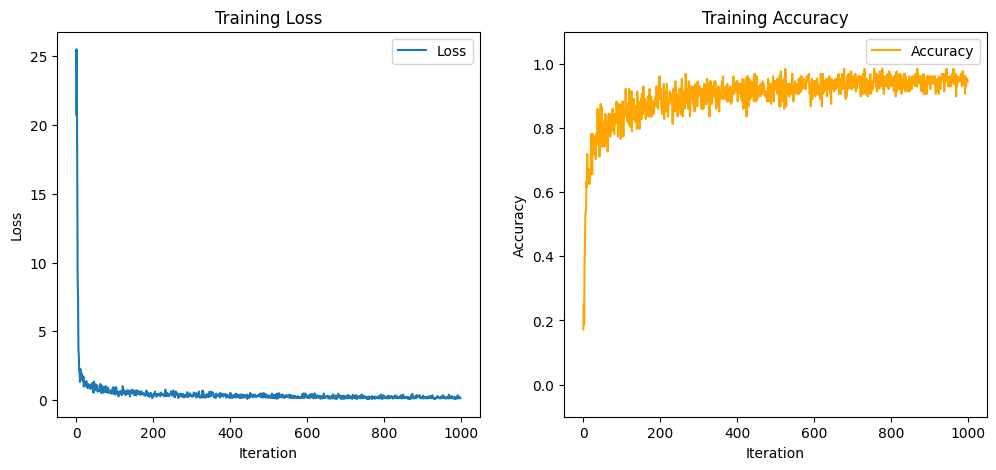

In [26]:
class ANN(torch.nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x

ann_model = ANN()
criterion = nn.NLLLoss(reduction='none')
optimizer = torch.optim.SGD(ann_model.parameters(), lr=0.001, momentum=0)
batch_size = 128
losses, accuracies = [], []

for epoch in (t := trange(1000)):
    sampled_indices = np.random.randint(0, X_train.shape[0], size=(batch_size))
    inputs = torch.tensor(X_train[sampled_indices].reshape((-1, 28*28))).float()
    labels = torch.tensor(y_train[sampled_indices]).long()
    
    ann_model.zero_grad()
    outputs = ann_model(inputs)
    predicted_labels = torch.argmax(outputs, dim=1)
    batch_accuracy = (predicted_labels == labels).float().mean()
    batch_loss = criterion(outputs, labels)
    batch_loss = batch_loss.mean()
    batch_loss.backward()
    optimizer.step()
    
    avg_batch_loss, avg_batch_accuracy = batch_loss.item(), batch_accuracy.item()
    losses.append(avg_batch_loss)
    accuracies.append(avg_batch_accuracy)
    t.set_description(f"loss {avg_batch_loss:.2f} accuracy {avg_batch_accuracy:.2f}")

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend()

plt.show()


In [28]:
y_val_preds = torch.argmax(model(torch.tensor(X_val.reshape((-1, 28*28))).float()), dim=1).numpy()
(y_val == y_val_preds).mean()

0.9252380952380952

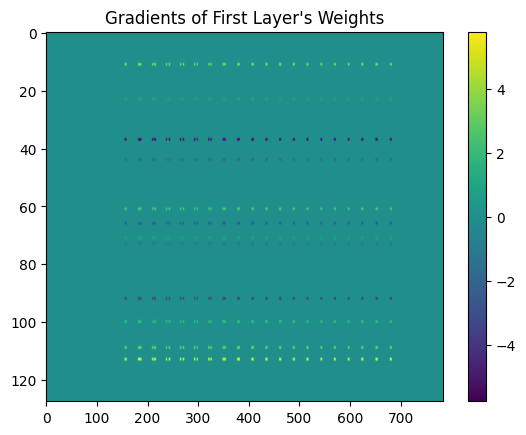

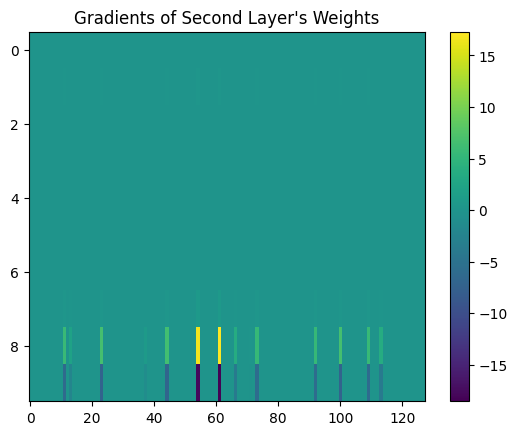

In [32]:
sample_indices = [0,1,2,3,4]
model.zero_grad()

# Forward pass: compute predicted outputs by passing inputs to the model
inputs = torch.tensor(X_val[sample_indices].reshape((-1, 28*28))).float()
outputs = model(inputs)

# Retain the gradients for outputs
outputs.retain_grad()

# Calculate the loss
labels = torch.tensor(y_val[sample_indices]).long()
loss = loss_function(outputs, labels).mean()
loss.retain_grad()
loss.backward()

# Visualize the gradients of the first layer's weights
plt.figure()
plt.title("Gradients of First Layer's Weights")
plt.imshow(model.l1.weight.grad.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()

# Create a new figure for the second layer's gradients
plt.figure()
plt.title("Gradients of Second Layer's Weights")
plt.imshow(model.l2.weight.grad.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()

plt.show()

In [34]:
def extract_weights(model):
    l1_weights = model.l1.weight.detach().numpy().T
    l2_weights = model.l2.weight.detach().numpy().T
    return l1_weights, l2_weights

def forward_pass(x, l1_weights, l2_weights):
    x = x.dot(l1_weights)
    x = np.maximum(x, 0) 
    x = x.dot(l2_weights)
    return x

def evaluate_with_numpy(X_test, Y_test, l1_weights, l2_weights):
    X_test_reshaped = X_test.reshape((-1, 28*28))
    test_preds_out = forward_pass(X_test_reshaped, l1_weights, l2_weights)
    test_preds = np.argmax(test_preds_out, axis=1)
    accuracy = (Y_test == test_preds).mean()
    return accuracy
l1_weights, l2_weights = extract_weights(model)
accuracy = evaluate_with_numpy(X_val, y_val, l1_weights, l2_weights)
print(f"Model accuracy using NumPy: {accuracy * 100:.2f}%")


Model accuracy using NumPy: 92.52%


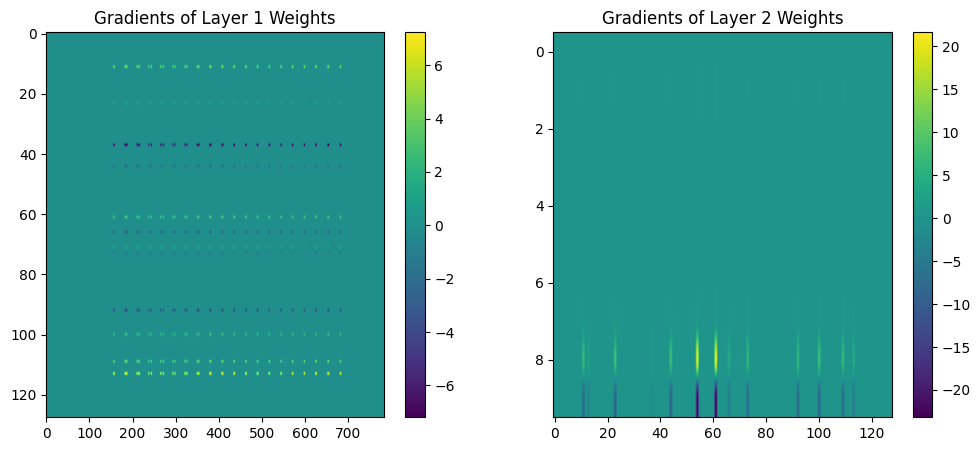

In [36]:
def logsumexp(x):
    """
    Compute the log-sum-exp of x for numerical stability.
    """
    c = x.max(axis=1)
    return c + np.log(np.exp(x - c.reshape((-1, 1))).sum(axis=1))

def forward(x, l1_weights, l2_weights):
    """
    Perform the forward pass through the network.
    """
    x_l1 = x.dot(l1_weights)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2_weights)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    return x_l1, x_relu, x_l2, x_lsm

def compute_loss(x_lsm, y):
    """
    Compute the loss using negative log likelihood.
    """
    target = np.zeros((len(y), 10), np.float32)
    target[range(target.shape[0]), y] = 1
    loss = (-target * x_lsm).mean(axis=1)
    return loss, target

def backward(x, x_relu, x_lsm, y, target, l2_weights):
    """
    Perform the backward pass and compute gradients.
    """
    batch_size = len(y)
    d_out = -target / batch_size
    dx_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))
    d_l2_weights = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2_weights.T)
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu
    d_l1_weights = x.T.dot(dx_l1)
    return d_l1_weights, d_l2_weights

def forward_backward(x, y, l1_weights, l2_weights):
    """
    Perform both forward and backward pass.
    """
    x_l1, x_relu, x_l2, x_lsm = forward(x, l1_weights, l2_weights)
    loss, target = compute_loss(x_lsm, y)
    d_l1_weights, d_l2_weights = backward(x, x_relu, x_lsm, y, target, l2_weights)
    return loss, x_l2, d_l1_weights, d_l2_weights

sample_indices = [0, 1, 2, 3]
x_sample = X_val[sample_indices].reshape((-1, 28*28))
y_sample = y_val[sample_indices]


loss, x_l2, d_l1_weights, d_l2_weights = forward_backward(x_sample, y_sample, l1_weights, l2_weights)

plt.figure(figsize=(12, 5))

# Gradients of layer 1 weights
plt.subplot(1, 2, 1)
plt.title("Gradients of Layer 1 Weights")
plt.imshow(d_l1_weights.T, aspect='auto')
plt.colorbar()

# Gradients of layer 2 weights
plt.subplot(1, 2, 2)
plt.title("Gradients of Layer 2 Weights")
plt.imshow(d_l2_weights.T, aspect='auto')
plt.colorbar()

plt.show()


loss 0.01 accuracy 0.97: 100%|██████████| 1000/1000 [00:03<00:00, 259.18it/s]


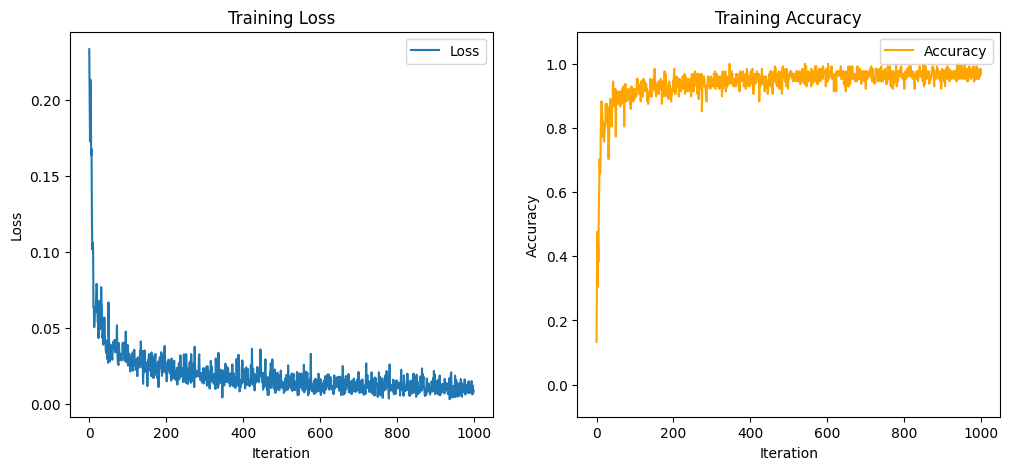

In [39]:
def layer_init(input_dim, output_dim, method='uniform'):
    if method == 'gaussian':
        weights = np.random.randn(input_dim, output_dim) / np.sqrt(input_dim * output_dim)
    elif method == 'uniform':
        weights = np.random.uniform(-1., 1., size=(input_dim, output_dim)) / np.sqrt(input_dim * output_dim)
    else:
        raise ValueError("Initialization method not supported.")
    return weights.astype(np.float32)


def forward_backward(x, y, l1_weights, l2_weights):
    target = np.zeros((len(y), 10), np.float32)
    target[range(target.shape[0]), y] = 1

    x_l1 = x.dot(l1_weights)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2_weights)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-target * x_lsm).mean(axis=1)

    d_out = -target / len(y)
    dx_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2_weights.T)
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu
    d_l1 = x.T.dot(dx_l1)

    return x_loss, x_l2, d_l1, d_l2

def logsumexp(x):
    c = x.max(axis=1)
    return c + np.log(np.exp(x - c.reshape((-1, 1))).sum(axis=1))

def plot_metrics(losses, accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.ylim(-0.1, 1.1)
    plt.legend()

    plt.show()

np.random.seed(123)
l1_weights = layer_init(784, 128, method='uniform')
l2_weights = layer_init(128, 10, method='uniform')

learning_rate = 0.001
batch_size = 128
losses, accuracies = [], []

for epoch in (t := trange(1000)):
    indices = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X_batch = X_train[indices].reshape((-1, 28*28))
    Y_batch = y_train[indices]

    x_loss, x_l2, d_l1_weights, d_l2_weights = forward_backward(X_batch, Y_batch, l1_weights, l2_weights)

    predictions = np.argmax(x_l2, axis=1)
    accuracy = (predictions == Y_batch).mean()

    l1_weights -= learning_rate * d_l1_weights
    l2_weights -= learning_rate * d_l2_weights

    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)

    t.set_description(f"loss {loss:.2f} accuracy {accuracy:.2f}")
plot_metrics(losses, accuracies)
